In [1]:
import fairlib
import torch
import numpy as np

In [2]:
args = {
    # The name of the dataset, corresponding dataloader will be used,
    "dataset":  "Moji",

    # Give a name to the exp, which will be used in the path
    "exp_id":"knn",
}

# Init the argument
options = fairlib.BaseOptions()
state = options.get_state(args=args, silence=True)

INFO:root:Unexpected args: ['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"1c3f633d-61c6-40ca-bf26-fac770577489"', '--shell=9002', '--transport="tcp"', '--iopub=9004']
INFO:root:Logging to ./results/dev\Moji\knn\output.log


2022-09-20 11:15:42 [INFO ]  ======================================== 2022-09-20 11:15:42 ========================================
2022-09-20 11:15:42 [INFO ]  Base directory is ./results/dev\Moji\knn
2022-09-20 11:15:42 [WARNING]  ./results/dev\Moji\knn\opt.yaml already exists, moved to ./results/dev\Moji\knn\old_opts\opt_2022_09_20__11_14_14.yaml
{'Moji': {'emb_size': 2304, 'num_classes': 2, 'num_groups': 2}, 'Bios_both': {'emb_size': 768, 'num_classes': 28, 'num_groups': 4}, 'Bios_intersection': {'emb_size': 768, 'num_classes': 28, 'num_groups': 4}, 'Bios_gender': {'emb_size': 768, 'num_classes': 28, 'num_groups': 2}, 'Bios_economy': {'emb_size': 768, 'num_classes': 28, 'num_groups': 2}, 'Trustpilot_gender': {'emb_size': 768, 'num_classes': 5, 'num_groups': 2}, 'Trustpilot_age': {'emb_size': 768, 'num_classes': 5, 'num_groups': 2}, 'Trustpilot_country': {'emb_size': 768, 'num_classes': 5, 'num_groups': 2}, 'Trustpilot_intersection': {'emb_size': 768, 'num_classes': 5, 'num_groups': 

In [3]:
fairlib.utils.seed_everything(2022)

# Init Model
model = fairlib.networks.get_main_model(state)

2022-09-20 11:15:43 [INFO ]  MLP( 
2022-09-20 11:15:43 [INFO ]    (output_layer): Linear(in_features=300, out_features=2, bias=True)
2022-09-20 11:15:43 [INFO ]    (AF): Tanh()
2022-09-20 11:15:43 [INFO ]    (hidden_layers): ModuleList(
2022-09-20 11:15:43 [INFO ]      (0): Linear(in_features=2304, out_features=300, bias=True)
2022-09-20 11:15:43 [INFO ]      (1): Tanh()
2022-09-20 11:15:43 [INFO ]      (2): Linear(in_features=300, out_features=300, bias=True)
2022-09-20 11:15:43 [INFO ]      (3): Tanh()
2022-09-20 11:15:43 [INFO ]    )
2022-09-20 11:15:43 [INFO ]    (criterion): CrossEntropyLoss()
2022-09-20 11:15:43 [INFO ]  )
2022-09-20 11:15:43 [INFO ]  Total number of parameters: 782402 



In [4]:
model.train_self()

2022-09-20 11:15:44 [INFO ]  Epoch:    0 [      0/  99998 ( 0%)]	Loss: 0.6913	 Data Time: 0.02s	Train Time: 1.59s
2022-09-20 11:15:45 [INFO ]  Epoch:    0 [  51200/  99998 (51%)]	Loss: 0.3782	 Data Time: 0.51s	Train Time: 0.10s
2022-09-20 11:15:46 [INFO ]  Evaluation at Epoch 0
2022-09-20 11:15:46 [INFO ]  Validation accuracy: 71.97	macro_fscore: 71.93	micro_fscore: 71.97	TPR_GAP: 38.58	FPR_GAP: 38.58	PPR_GAP: 37.95	
2022-09-20 11:15:46 [INFO ]  Test accuracy: 71.71	macro_fscore: 71.67	micro_fscore: 71.71	TPR_GAP: 40.99	FPR_GAP: 40.99	PPR_GAP: 40.39	
2022-09-20 11:15:46 [INFO ]  Epoch:    1 [      0/  99998 ( 0%)]	Loss: 0.3970	 Data Time: 0.02s	Train Time: 0.00s
2022-09-20 11:15:47 [INFO ]  Epoch:    1 [  51200/  99998 (51%)]	Loss: 0.3711	 Data Time: 0.55s	Train Time: 0.10s
2022-09-20 11:15:47 [INFO ]  Epochs since last improvement: 1
2022-09-20 11:15:47 [INFO ]  Evaluation at Epoch 1
2022-09-20 11:15:47 [INFO ]  Validation accuracy: 72.04	macro_fscore: 72.02	micro_fscore: 72.04	TPR_GA

# KNN based labels

In [5]:
from fairlib.src.networks.knn_labels import KNN_labels
from sklearn.metrics import mutual_info_score
from collections import Counter

import pandas as pd
import seaborn as sns

In [6]:
criterion = torch.nn.CrossEntropyLoss()


In [7]:
def k1_ratio_analysis(knn_labels, group_labels, class_labels, metadata = {}, silence = True):
    # Within a class, what is the ratio of being assigned knn label 1 of each group
    tuple_g_labels = [(knn_g, g, y) for knn_g, g, y in zip(knn_labels, group_labels,class_labels)]
    counts = Counter(tuple_g_labels)
    
    k1_y_g_ratio_list = []
    for _y_label in set(class_labels):
        for _g_label in set(group_labels):
            k1_y_g_ratio = counts[(1, _g_label, _y_label)] / (counts[(1, _g_label, _y_label)]+counts[(0, _g_label, _y_label)])
            if not silence:
                print("Target class {}, protected group {}:".format(_y_label, _g_label), k1_y_g_ratio)
            
            k1_y_g_ratio_dict = metadata.copy()
            k1_y_g_ratio_dict["target"] = _y_label
            k1_y_g_ratio_dict["group"] = _g_label
            k1_y_g_ratio_dict["ratio"] = k1_y_g_ratio
            
            k1_y_g_ratio_list.append(k1_y_g_ratio_dict)
    return k1_y_g_ratio_list

In [8]:
def vary_hyperparameters(criterion, tags, text, model, predictions, loss, batch, p = 2, k = 5, average_first = False):

    knn_g_labels = KNN_labels(
        criterion = criterion, tags = tags, text = text, model = model, 
        predictions = predictions, loss = loss, p = p, k = k, average_first = average_first)
        
    return list(knn_g_labels.detach().cpu().numpy()), list(batch[1].cpu().numpy()), list(batch[2].cpu().numpy())

In [9]:
def mutual_information_analysis(p, k, batch_iterator = state.train_generator):

    knn_label_list = []
    class_label_list = []
    group_label_list = []
    prediction_list = []

    for batch in batch_iterator:

        text = batch[0].squeeze()
        tags = batch[1].long().squeeze()

        text = text.to(state.device)
        tags = tags.to(state.device)

        predictions = model(text)
        loss = criterion(predictions, tags)

        knn_label, class_label, group_label = vary_hyperparameters(
                criterion = criterion, tags = tags, text = text, model = model, loss = loss,
                predictions = predictions, batch = batch, p = 2, k = 1,  average_first=True
                )

        # k1_ratio_analysis(
        #     knn_labels = knn_label, 
        #     group_labels = group_label, 
        #     class_labels = class_label, metadata = {"p":p,"k":k}, silence = False)

        knn_label_list = knn_label_list + knn_label
        class_label_list = class_label_list + class_label
        group_label_list = group_label_list + group_label
        prediction_list = prediction_list + list(torch.argmax(predictions, axis=1).detach().cpu().numpy())

    k1_y_g_ratio_list = k1_ratio_analysis(
            knn_labels = knn_label_list, 
            group_labels = group_label_list, 
            class_labels = class_label_list, metadata = {"p":p,"k":k}, silence = False)


    # knn_label = np.array(knn_label_list)
    # class_label = np.array(class_label_list)
    # group_label = np.array(group_label_list)

    # z_y1_array = knn_label[class_label==1]
    # g_y1_array = group_label[class_label==1]

    # z_y0_array = knn_label[class_label==0]
    # g_y0_array = group_label[class_label==0]

    # mi1 = mutual_info_score(g_y1_array, z_y1_array)
    # mi0 = mutual_info_score(g_y0_array, z_y0_array)
    
    # print(mi1, mi0)
    # return mi1, mi0, pd.DataFrame(k1_y_g_ratio_list)

    return pd.DataFrame(k1_y_g_ratio_list), knn_label_list, class_label_list, group_label_list, prediction_list

In [10]:
k1_y_g_ratio_list, knn_label, class_label, group_label, prediction = mutual_information_analysis(p=2, k=1)

Target class 0, protected group 0: 0.156975
Target class 0, protected group 1: 0.6760676067606761
Target class 1, protected group 0: 0.5915591559155916
Target class 1, protected group 1: 0.180425


In [28]:
k1_y_g_ratio_list

,p,k,target,group,ratio
0,2,14,0,0,0.157850
1,2,14,0,1,0.675368
2,2,14,1,0,0.588759
3,2,14,1,1,0.180575


In [11]:
from fairlib.src.evaluators import gap_eval_scores, confusion_matrix_based_scores

In [12]:
_, confs = gap_eval_scores(
    y_pred=prediction,
    y_true=class_label, 
    protected_attribute=group_label,
    args = model.args,
)

In [19]:
metrics_group0 = confusion_matrix_based_scores(confs[0])

In [18]:
metrics_group1 = confusion_matrix_based_scores(confs[1])

In [21]:
metrics_results = [metrics_group0, metrics_group1]

In [20]:
metrics_group1

{'TPR': array([0.45954595, 0.92505   ]),
 'TNR': array([0.92505   , 0.45954595]),
 'PPV': array([0.60516265, 0.8725652 ]),
 'NPV': array([0.8725652 , 0.60516265]),
 'FPR': array([0.07495   , 0.54045405]),
 'FNR': array([0.54045405, 0.07495   ]),
 'FDR': array([0.39483735, 0.1274348 ]),
 'ACC': array([0.83195664, 0.83195664]),
 'PPR': array([0.15186304, 0.84813696])}

In [31]:
merics_y_g = []
for _target_class in [0,1]:
    for _group_class in [0,1]:
        merics_y_g.append(
            {
                "target": _target_class,
                "group":_group_class,
                "PPR": metrics_results[_group_class]['PPR'][_target_class],
                "TPR": metrics_results[_group_class]['TPR'][_target_class],
                "FPR": metrics_results[_group_class]['FPR'][_target_class],
                "PPV": metrics_results[_group_class]['PPV'][_target_class],
                "NPV": metrics_results[_group_class]['NPV'][_target_class],
            }
        )

In [27]:
print(pd.DataFrame(merics_y_g).to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
 class &  group &      PPR &      TPR &      FPR &      PPV &      NPV \\
\midrule
     0 &      0 & 0.808656 & 0.913475 & 0.389339 & 0.903715 & 0.638236 \\
     0 &      1 & 0.151863 & 0.459546 & 0.074950 & 0.605163 & 0.872565 \\
     1 &      0 & 0.191344 & 0.610661 & 0.086525 & 0.638236 & 0.903715 \\
     1 &      1 & 0.848137 & 0.925050 & 0.540454 & 0.872565 & 0.605163 \\
\bottomrule
\end{tabular}



In [17]:
k1_ratio_list = []

for _k_value in range(1,15):
    k1_y_g_ratio_list, _,_,_,_ = mutual_information_analysis(p=2, k=_k_value)
    k1_ratio_list.append(k1_y_g_ratio_list)

k1_ratio_df = pd.concat(k1_ratio_list).reset_index(drop=True)

Target class 0, protected group 0: 0.15785
Target class 0, protected group 1: 0.6752675267526753
Target class 1, protected group 0: 0.5887588758875888
Target class 1, protected group 1: 0.1807
Target class 0, protected group 0: 0.15775
Target class 0, protected group 1: 0.6738673867386739
Target class 1, protected group 0: 0.5890589058905891
Target class 1, protected group 1: 0.18
Target class 0, protected group 0: 0.15815
Target class 0, protected group 1: 0.6753675367536753
Target class 1, protected group 0: 0.5905590559055905
Target class 1, protected group 1: 0.180175
Target class 0, protected group 0: 0.157425
Target class 0, protected group 1: 0.6748674867486749
Target class 1, protected group 0: 0.5892589258925892
Target class 1, protected group 1: 0.17995
Target class 0, protected group 0: 0.15805
Target class 0, protected group 1: 0.6757675767576757
Target class 1, protected group 0: 0.5905590559055905
Target class 1, protected group 1: 0.1808
Target class 0, protected group 0

<AxesSubplot:xlabel='k', ylabel='ratio'>

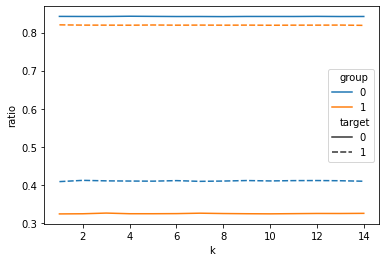

In [ ]:
sns.lineplot(
    x = "k",
    y="ratio",
    style="target",
    hue = "group",
    data = k1_ratio_df
    )

In [36]:
result_df_list = []

for i in range(5):

    args = {
        # The name of the dataset, corresponding dataloader will be used,
        "dataset":  "Moji",

        # Give a name to the exp, which will be used in the path
        "exp_id":"knn",
    }

    # Init the argument
    options = fairlib.BaseOptions()
    state = options.get_state(args=args, silence=True)

    fairlib.utils.seed_everything(2022+i)

    # Init Model
    model = fairlib.networks.get_main_model(state)
    model.train_self()

    k1_y_g_ratio_list, knn_label, class_label, group_label, prediction = mutual_information_analysis(p=2, k=1)

    _, confs = gap_eval_scores(
        y_pred=prediction,
        y_true=class_label, 
        protected_attribute=group_label,
        args = model.args,
    )

    metrics_group0 = confusion_matrix_based_scores(confs[0])
    metrics_group1 = confusion_matrix_based_scores(confs[1])
    metrics_results = [metrics_group0, metrics_group1]

    merics_y_g = []
    for _target_class in [0,1]:
        for _group_class in [0,1]:
            merics_y_g.append(
                {
                    "target": _target_class,
                    "group":_group_class,
                    "PPR": metrics_results[_group_class]['PPR'][_target_class],
                    "TPR": metrics_results[_group_class]['TPR'][_target_class],
                    "FPR": metrics_results[_group_class]['FPR'][_target_class],
                    "PPV": metrics_results[_group_class]['PPV'][_target_class],
                    "NPV": metrics_results[_group_class]['NPV'][_target_class],
                }
            )

    result_df = k1_y_g_ratio_list.set_index(["target","group"]).join(pd.DataFrame(merics_y_g).set_index(["target","group"])).reset_index()

    result_df_list.append(result_df)

2022-09-20 13:20:21 [INFO ]  Unexpected args: ['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"1c3f633d-61c6-40ca-bf26-fac770577489"', '--shell=9002', '--transport="tcp"', '--iopub=9004']
2022-09-20 13:20:21 [INFO ]  Logging to ./results/dev\Moji\knn\output.log
2022-09-20 13:20:21 [WARNING]  Log file already exists, will append
2022-09-20 13:20:21 [INFO ]  ======================================== 2022-09-20 13:20:21 ========================================
2022-09-20 13:20:21 [INFO ]  Base directory is ./results/dev\Moji\knn
2022-09-20 13:20:21 [WARNING]  ./results/dev\Moji\knn\opt.yaml already exists, moved to ./results/dev\Moji\knn\old_opts\opt_2022_09_20__13_19_25.yaml
{'Moji': {'emb_size': 2304, 'num_classes': 2, 'num_groups': 2}, 'Bios_both': {'emb_size': 768, 'num_classes': 28, 'num_groups': 4}, 'Bios_intersection': {'emb_size': 768, 'num_classes': 28, 'num_groups': 4}, 'Bios_gender': {'emb_size': 768, 

In [46]:
print((pd.concat(result_df_list)*100).groupby(["target","group"]).agg(["mean", "std"]).to_latex())

\begin{tabular}{llrrrrrrrrrrrrrrrr}
\toprule
    &     & \multicolumn{2}{l}{p} & \multicolumn{2}{l}{k} & \multicolumn{2}{l}{ratio} & \multicolumn{2}{l}{PPR} & \multicolumn{2}{l}{TPR} & \multicolumn{2}{l}{FPR} & \multicolumn{2}{l}{PPV} & \multicolumn{2}{l}{NPV} \\
    &     &   mean &  std &   mean &  std &       mean &       std &       mean &       std &       mean &       std &       mean &       std &       mean &       std &       mean &       std \\
target & group &        &      &        &      &            &           &            &           &            &           &            &           &            &           &            &           \\
\midrule
0   & 0   &  200.0 &  0.0 &  100.0 &  0.0 &  17.019000 &  1.242669 &  79.934799 &  0.760515 &  91.176000 &  0.688489 &  34.965497 &  3.137330 &  91.255727 &  0.725637 &  64.824876 &  2.239953 \\
    & 100 &  200.0 &  0.0 &  100.0 &  0.0 &  68.502850 &  1.679611 &  14.269485 &  0.695365 &  45.748575 &  2.627558 &   6.400500 &  0.75